In [1]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa #To deal with Audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import HTML, IFrame
import math


from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

C:\Users\Admin\anaconda3\envs\GPU_PhD\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Admin\anaconda3\envs\GPU_PhD\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\Admin\anaconda3\envs\GPU_PhD\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
data_path = "DataSet/"
print(os.listdir(data_path))

['MR', 'MS', 'Normal', 'Unlabel', 'unlabelledtest']


In [3]:
tarin_data      = data_path   # It appears to be the base directory for training data.  
# This variable is assigned the value of data_path
unlabel_data    = data_path  + "unlabelledtest/" # 

normal_data     = tarin_data + '/Normal/'  #This could be a directory containing data categorized as "Normal."
mr_data     = tarin_data + '/MR/'  #This could be a directory containing data categorized as "MR."
ms_data = tarin_data + '/MS/'      #This could be a directory containing data categorized as "MS."

In [4]:
print("Normal files:", len(os.listdir(normal_data))) #length of normal training sounds
print("MR files:",len(os.listdir(mr_data))) #length of MR training sounds 
print("MS files", len(os.listdir(ms_data))) #length of MStraining sounds 


#calculates the total count of training sounds by adding the counts of files in all three categories
print('TOTAL TRAIN SOUNDS:', len(os.listdir(normal_data)) 
                              + len(os.listdir(mr_data))
                              + len(os.listdir(ms_data)))

Normal files: 160
MR files: 160
MS files 160
TOTAL TRAIN SOUNDS: 480


In [5]:
# calculates and prints the number of unlabel_data sound files
print("Test sounds: ", len(os.listdir(unlabel_data)))

Test sounds:  120


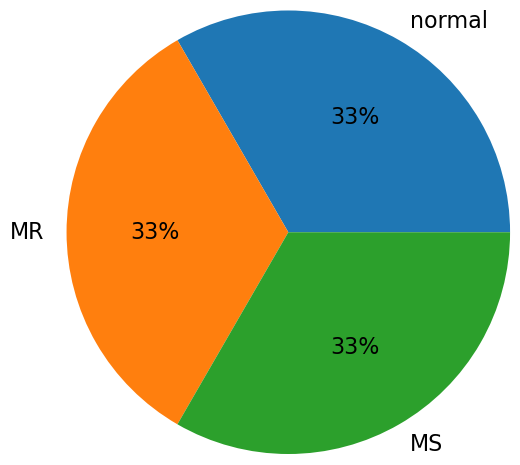

In [6]:
# plot pie graph of 3labels normal, MR and MS
x = np.array([len(os.listdir(normal_data)),
              len(os.listdir(mr_data)),
              len(os.listdir(ms_data))])
labels = ['normal', 'MR', 'MS']
y=plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, textprops={'fontsize': 16})
plt.show(y)

In [7]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [11]:
def load_file_data (folder, file_names, duration=10, sr=22050):
    '''
        Extract MFCC feature from the Sound data from the audio data. 
        Augmentation of sound data by adding Noise, streaching and shifting.
        52 features are extracted from each audio data and used to train the model.
        
        Args: 
            dir_: Input directory to the Sound input file.
        
        Returns:
            data: list of features extracted from the sound file.
    '''
    input_length=sr*duration
    features = 52
    data = []
    for file_name in file_names:
        try:
            sound_file = folder+file_name
            X, sr = librosa.load( sound_file, sr=sr, duration=duration) 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                X = librosa.util.fix_length(X, input_length)  
                
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=features).T,axis=0) 
            feature = np.array(mfccs).reshape([-1,1])
            data.append(feature)
            
            stretch_data_1 = stretch (X, 0.8)
            mfccs_stretch_1 = np.mean(librosa.feature.mfcc(y=stretch_data_1, sr=sr, n_mfcc=features).T,axis=0) 
            feature_1 = np.array(mfccs_stretch_1).reshape([-1,1])
            data.append(feature_1)
            
            stretch_data_2 = stretch (X, 1.2) 
            mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=stretch_data_2, sr=sr, n_mfcc=features).T,axis=0) 
            feature_2 = np.array(mfccs_stretch_2).reshape([-1,1])
            data.append(feature_2)
            
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)        
        
    return data

In [9]:
# simple encoding of categories, convert to only 3 types:
# Normal (Include extrahls and extrastole)
# Murmur
# Artifact

# Map label text to integer
CLASSES = ['MS','MR','Normal']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'MS': 0, 'MR': 1, 'Normal': 2}
 
{0: 'MS', 1: 'MR', 2: 'Normal'}


In [12]:
# 22 KHz
SAMPLE_RATE = 22050
# 10 seconds
MAX_SOUND_CLIP_DURATION=10

ms_files = fnmatch.filter(os.listdir(ms_data), '*.wav')
ms_sounds = load_file_data (folder=ms_data, file_names = ms_files, duration=MAX_SOUND_CLIP_DURATION)
ms_labels = [0 for items in ms_sounds]

normal_files = fnmatch.filter(os.listdir(normal_data), '*.wav')
normal_sounds = load_file_data(folder=normal_data,file_names=normal_files, duration=MAX_SOUND_CLIP_DURATION)
normal_labels = [2 for items in normal_sounds]


mr_files = fnmatch.filter(os.listdir(mr_data), '*.wav')
mr_sounds = load_file_data(folder=mr_data,file_names=mr_files, duration=MAX_SOUND_CLIP_DURATION)
mr_labels = [1 for items in mr_sounds]



print ("Loading Done")

fixing audio lenght : New_MS_007.wav
Error encountered while parsing file:  New_MS_007.wav
fixing audio lenght : New_MS_008.wav
Error encountered while parsing file:  New_MS_008.wav
fixing audio lenght : New_MS_009.wav
Error encountered while parsing file:  New_MS_009.wav
fixing audio lenght : New_MS_010.wav
Error encountered while parsing file:  New_MS_010.wav
fixing audio lenght : New_MS_011.wav
Error encountered while parsing file:  New_MS_011.wav
fixing audio lenght : New_MS_012.wav
Error encountered while parsing file:  New_MS_012.wav
fixing audio lenght : New_MS_013.wav
Error encountered while parsing file:  New_MS_013.wav
fixing audio lenght : New_MS_014.wav
Error encountered while parsing file:  New_MS_014.wav
fixing audio lenght : New_MS_015.wav
Error encountered while parsing file:  New_MS_015.wav
fixing audio lenght : New_MS_016.wav
Error encountered while parsing file:  New_MS_016.wav
fixing audio lenght : New_MS_017.wav
Error encountered while parsing file:  New_MS_017.wav

fixing audio lenght : New_MS_184.wav
Error encountered while parsing file:  New_MS_184.wav
fixing audio lenght : New_MS_185.wav
Error encountered while parsing file:  New_MS_185.wav
fixing audio lenght : New_MS_186.wav
Error encountered while parsing file:  New_MS_186.wav
fixing audio lenght : New_MS_187.wav
Error encountered while parsing file:  New_MS_187.wav
fixing audio lenght : New_MS_188.wav
Error encountered while parsing file:  New_MS_188.wav
fixing audio lenght : New_MS_189.wav
Error encountered while parsing file:  New_MS_189.wav
fixing audio lenght : New_MS_190.wav
Error encountered while parsing file:  New_MS_190.wav
fixing audio lenght : New_MS_191.wav
Error encountered while parsing file:  New_MS_191.wav
fixing audio lenght : New_MS_192.wav
Error encountered while parsing file:  New_MS_192.wav
fixing audio lenght : New_N_001.wav
Error encountered while parsing file:  New_N_001.wav
fixing audio lenght : New_N_002.wav
Error encountered while parsing file:  New_N_002.wav
fix

fixing audio lenght : New_N_166.wav
Error encountered while parsing file:  New_N_166.wav
fixing audio lenght : New_N_167.wav
Error encountered while parsing file:  New_N_167.wav
fixing audio lenght : New_N_168.wav
Error encountered while parsing file:  New_N_168.wav
fixing audio lenght : New_N_169.wav
Error encountered while parsing file:  New_N_169.wav
fixing audio lenght : New_N_170.wav
Error encountered while parsing file:  New_N_170.wav
fixing audio lenght : New_N_171.wav
Error encountered while parsing file:  New_N_171.wav
fixing audio lenght : New_N_172.wav
Error encountered while parsing file:  New_N_172.wav
fixing audio lenght : New_N_173.wav
Error encountered while parsing file:  New_N_173.wav
fixing audio lenght : New_N_174.wav
Error encountered while parsing file:  New_N_174.wav
fixing audio lenght : New_N_175.wav
Error encountered while parsing file:  New_N_175.wav
fixing audio lenght : New_N_176.wav
Error encountered while parsing file:  New_N_176.wav
fixing audio lenght :

fixing audio lenght : New_MR_163.wav
Error encountered while parsing file:  New_MR_163.wav
fixing audio lenght : New_MR_164.wav
Error encountered while parsing file:  New_MR_164.wav
fixing audio lenght : New_MR_165.wav
Error encountered while parsing file:  New_MR_165.wav
fixing audio lenght : New_MR_166.wav
Error encountered while parsing file:  New_MR_166.wav
fixing audio lenght : New_MR_167.wav
Error encountered while parsing file:  New_MR_167.wav
fixing audio lenght : New_MR_168.wav
Error encountered while parsing file:  New_MR_168.wav
fixing audio lenght : New_MR_169.wav
Error encountered while parsing file:  New_MR_169.wav
fixing audio lenght : New_MR_171.wav
Error encountered while parsing file:  New_MR_171.wav
fixing audio lenght : New_MR_172.wav
Error encountered while parsing file:  New_MR_172.wav
fixing audio lenght : New_MR_173.wav
Error encountered while parsing file:  New_MR_173.wav
fixing audio lenght : New_MR_174.wav
Error encountered while parsing file:  New_MR_174.wav

In [11]:
# unlabel_datala files
unlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), '*.wav')
unlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
unlabelledtest_labels = [-1 for items in unlabelledtest_sounds]


print ("Loading of unlabel data done")

fixing audio lenght : unlabelledtest (1).wav
fixing audio lenght : unlabelledtest (10).wav


C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Pass size=220500 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Pass rate=1.2 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  # Remove the CWD from sys.path while we load stuff.


fixing audio lenght : unlabelledtest (100).wav
fixing audio lenght : unlabelledtest (101).wav
fixing audio lenght : unlabelledtest (102).wav
fixing audio lenght : unlabelledtest (103).wav
fixing audio lenght : unlabelledtest (104).wav
fixing audio lenght : unlabelledtest (105).wav
fixing audio lenght : unlabelledtest (106).wav
fixing audio lenght : unlabelledtest (107).wav
fixing audio lenght : unlabelledtest (108).wav
fixing audio lenght : unlabelledtest (109).wav
fixing audio lenght : unlabelledtest (11).wav
fixing audio lenght : unlabelledtest (110).wav
fixing audio lenght : unlabelledtest (111).wav
fixing audio lenght : unlabelledtest (112).wav
fixing audio lenght : unlabelledtest (113).wav
fixing audio lenght : unlabelledtest (114).wav
fixing audio lenght : unlabelledtest (115).wav
fixing audio lenght : unlabelledtest (116).wav
fixing audio lenght : unlabelledtest (117).wav
fixing audio lenght : unlabelledtest (118).wav
fixing audio lenght : unlabelledtest (119).wav
fixing audio l

In [14]:
#combine set-a and set-b 
x_data = np.concatenate((ms_sounds,normal_sounds, mr_sounds))

y_data = np.concatenate((ms_labels,normal_labels, mr_labels))

test_x = unlabelledtest_sounds
test_y = unlabelledtest_labels

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  1440 360


In [48]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.85, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.176, random_state=42, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

In [133]:
# Print shapes for debugging
print("Shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("test_y:", test_y.shape)

Shapes:
x_train: (1008, 52)
y_train: (1008,)
x_val: (216, 52)
y_val: (216,)
x_test: (216, 52)
y_test: (216,)
test_y: (360, 3, 3, 3, 3)


In [53]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
y_train = np.argmax(y_train, axis=1)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))
#y_test = np.argmax(y_test, axis=1)

In [58]:
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1]))

In [59]:
y_val = np.argmax(y_val, axis=1)

In [51]:
# Print shapes for debugging
print("Shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("test_y:", test_y.shape)

Shapes:
x_train: (1008, 52)
y_train: (1008, 3)
x_val: (216, 52, 1)
y_val: (216, 3)
x_test: (216, 52)
y_test: (216,)
test_y: (360, 3, 3, 3, 3)


### LogisticRegression

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
logi_reg=LogisticRegression()
logi_reg.fit(x_train,y_train)
ypred_logi=logi_reg.predict(x_test)
acc_logi=accuracy_score(y_test,ypred_logi)
print(f"Logistic Regression Accuracy_score:{acc_logi*100}%")

Logistic Regression Accuracy_score:95.37037037037037%


C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [55]:
cm_logi=confusion_matrix(y_test,ypred_logi)
print(cm_logi)

[[65  3  0]
 [ 5 60  0]
 [ 2  0 81]]


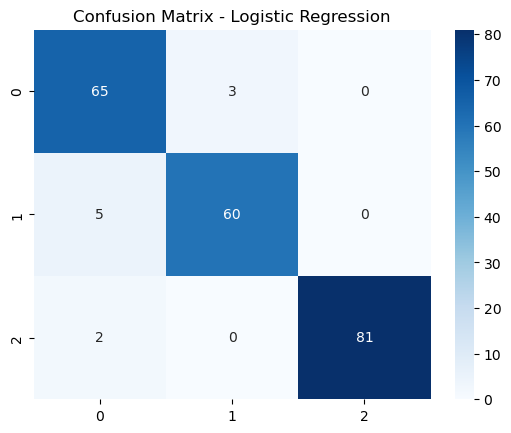

In [123]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# Assuming 'cm_logi' is your confusion matrix data
sb.heatmap(cm_logi, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

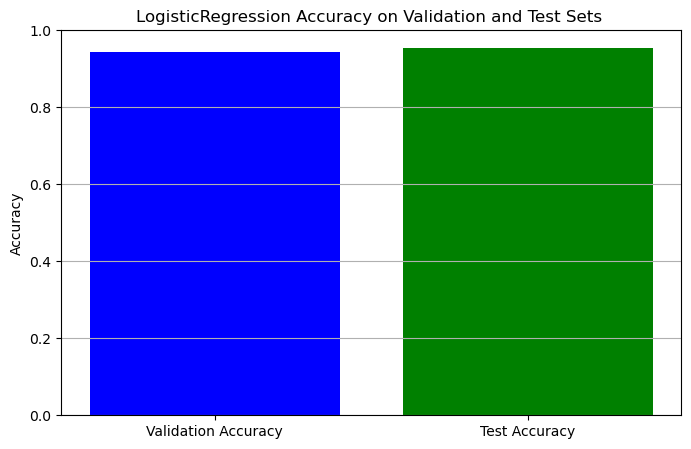

In [60]:
# Evaluate on validation data and calculate accuracy
val_predictions = logi_reg.predict(x_val) 
val_accuracy = accuracy_score(y_val, val_predictions)

# Evaluate on test data and calculate accuracy
test_predictions = logi_reg.predict(x_test) 
test_accuracy = accuracy_score(y_test, test_predictions)

# Plotting the accuracy
labels = ['Validation Accuracy', 'Test Accuracy']
accuracy_scores = [val_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('LogisticRegression Accuracy on Validation and Test Sets ')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(axis='y')
plt.show()

### RandomForest

In [61]:
from sklearn.ensemble import RandomForestClassifier
mod_RF=RandomForestClassifier()
mod_RF.fit(x_train,y_train)
pred_RF=mod_RF.predict(x_test)

In [62]:
acc_RF=accuracy_score(y_test,pred_RF)
print(acc_RF*100, '%')

99.07407407407408 %


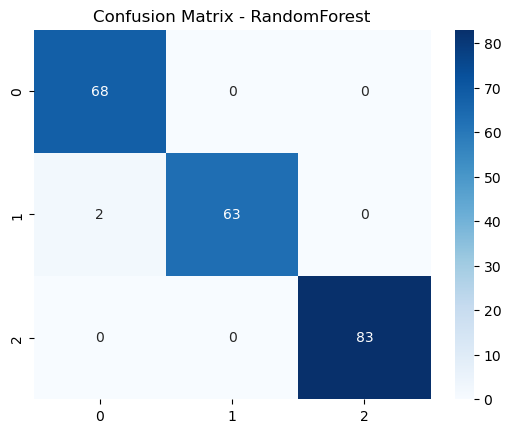

In [122]:
cm_RF=confusion_matrix(y_test,pred_RF)

sb.heatmap(cm_RF, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - RandomForest")
plt.show()

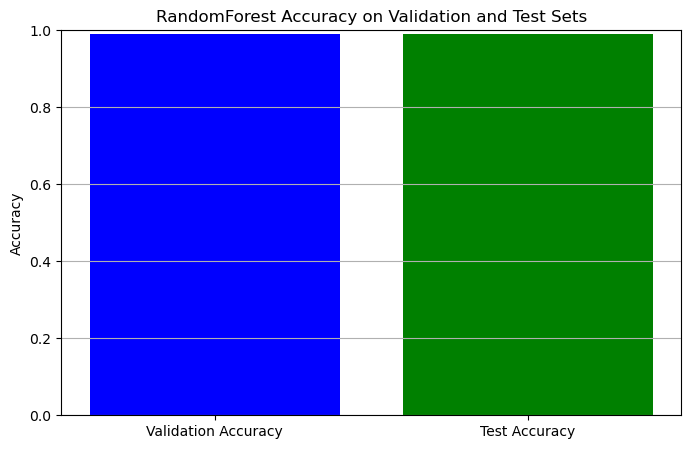

In [86]:
# Train your machine learning model on the training data and make predictions
mod_RF=RandomForestClassifier()
mod_RF.fit(x_train,y_train)

# Evaluate on validation data and calculate accuracy
val_predictions = mod_RF.predict(x_val) 
val_accuracy = accuracy_score(y_val, val_predictions)

# Evaluate on test data and calculate accuracy
test_predictions = mod_RF.predict(x_test) 
test_accuracy = accuracy_score(y_test, test_predictions)

# Plotting the accuracy
labels = ['Validation Accuracy', 'Test Accuracy']
accuracy_scores = [val_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('RandomForest Accuracy on Validation and Test Sets')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(axis='y')
plt.show()

### AdaBoost

In [65]:
from sklearn.ensemble import AdaBoostClassifier
mod_ada=AdaBoostClassifier()
mod_ada.fit(x_train,y_train)
pred_ada=mod_ada.predict(x_test)

In [66]:
acc_ada=accuracy_score(y_test,pred_ada)
print(acc_ada*100, '%')

87.96296296296296 %


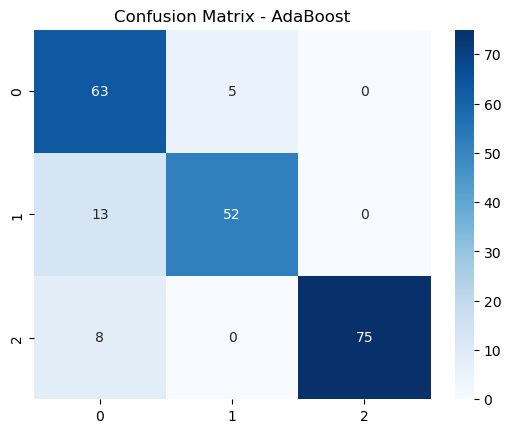

In [121]:
cm_ada=confusion_matrix(y_test,pred_ada)

sb.heatmap(cm_ada, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - AdaBoost")
plt.show()

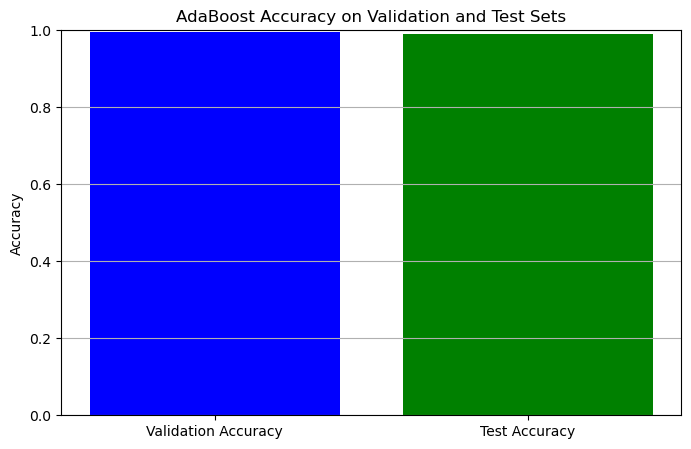

In [88]:
# Train your machine learning model on the training data and make predictions
mod_ada=RandomForestClassifier()
mod_ada.fit(x_train,y_train)

# Evaluate on validation data and calculate accuracy
val_predictions = mod_ada.predict(x_val) 
val_accuracy = accuracy_score(y_val, val_predictions)

# Evaluate on test data and calculate accuracy
test_predictions = mod_ada.predict(x_test) 
test_accuracy = accuracy_score(y_test, test_predictions)

# Plotting the accuracy
labels = ['Validation Accuracy', 'Test Accuracy']
accuracy_scores = [val_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('AdaBoost Accuracy on Validation and Test Sets')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(axis='y')
plt.show()

### SVM

In [144]:
from sklearn.svm import SVC
mod_svc=SVC(kernel='linear',probability = True)
mod_svc.fit(x_train,y_train)
pred_svc=mod_svc.predict(x_test)
acc_svc=accuracy_score(y_test,pred_svc)
print(acc_svc*100,'%')

99.07407407407408 %


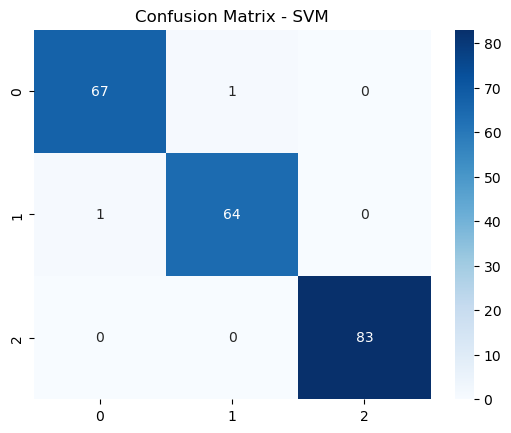

In [140]:
cm_svc=confusion_matrix(y_test,pred_svc)

sb.heatmap(cm_svc, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.show()

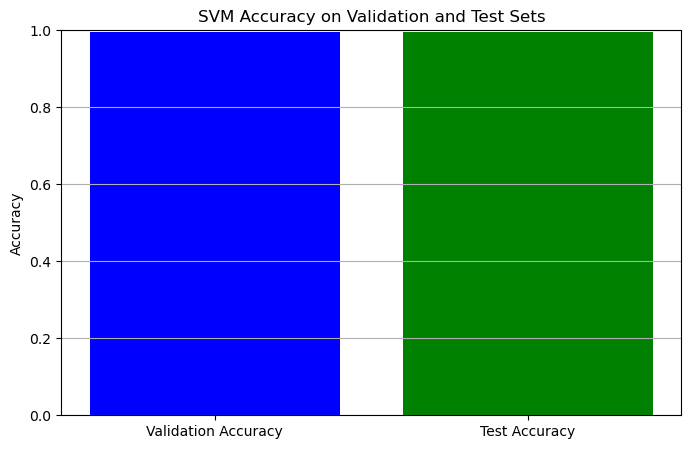

In [89]:
# Train your machine learning model on the training data and make predictions
mod_svc=RandomForestClassifier()
mod_svc.fit(x_train,y_train)

# Evaluate on validation data and calculate accuracy
val_predictions = mod_svc.predict(x_val) 
val_accuracy = accuracy_score(y_val, val_predictions)

# Evaluate on test data and calculate accuracy
test_predictions = mod_svc.predict(x_test) 
test_accuracy = accuracy_score(y_test, test_predictions)

# Plotting the accuracy
labels = ['Validation Accuracy', 'Test Accuracy']
accuracy_scores = [val_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('SVM Accuracy on Validation and Test Sets')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(axis='y')
plt.show()

### Decision Tree

In [70]:
from sklearn.tree import DecisionTreeClassifier
# Create a Decision Tree classifier with optional parameters
mod_dt = DecisionTreeClassifier()
# Fit the model to the training data
mod_dt.fit(x_train, y_train)
# Make predictions on the test data
pred_dt = mod_dt.predict(x_test)
# Calculate the accuracy of the model
acc_dt = accuracy_score(y_test, pred_dt)
# Print the accuracy in percentage form
print(acc_dt * 100, '%')

98.61111111111111 %


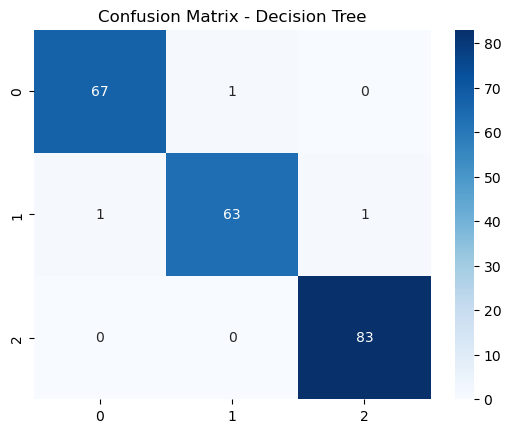

In [119]:
cm_dt=confusion_matrix(y_test,pred_dt)

sb.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

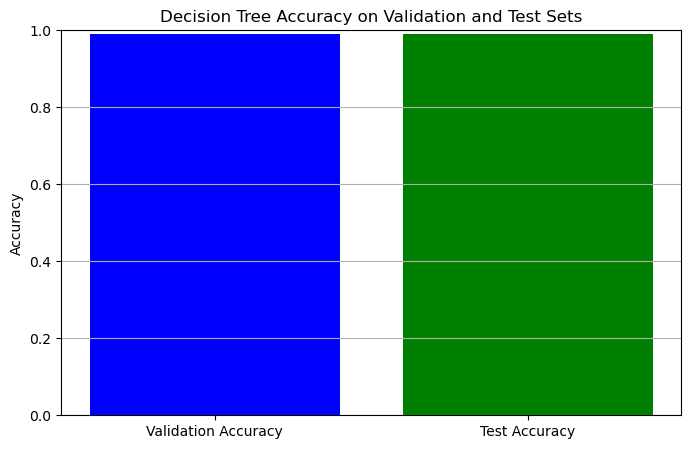

In [90]:
# Train your machine learning model on the training data and make predictions
mod_dt=RandomForestClassifier()
mod_dt.fit(x_train,y_train)

# Evaluate on validation data and calculate accuracy
val_predictions = mod_dt.predict(x_val) 
val_accuracy = accuracy_score(y_val, val_predictions)

# Evaluate on test data and calculate accuracy
test_predictions = mod_dt.predict(x_test) 
test_accuracy = accuracy_score(y_test, test_predictions)

# Plotting the accuracy
labels = ['Validation Accuracy', 'Test Accuracy']
accuracy_scores = [val_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('Decision Tree Accuracy on Validation and Test Sets')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(axis='y')
plt.show()

### KNN

In [72]:
from sklearn.neighbors import KNeighborsClassifier
# Create a KNN classifier with optional parameters
mod_knn = KNeighborsClassifier()
# Fit the model to the training data
mod_knn.fit(x_train, y_train)
# Make predictions on the test data
pred_knn = mod_knn.predict(x_test)
# Calculate the accuracy of the model
acc_knn = accuracy_score(y_test, pred_knn)
# Print the accuracy in percentage form
print(acc_knn * 100, '%')

98.14814814814815 %


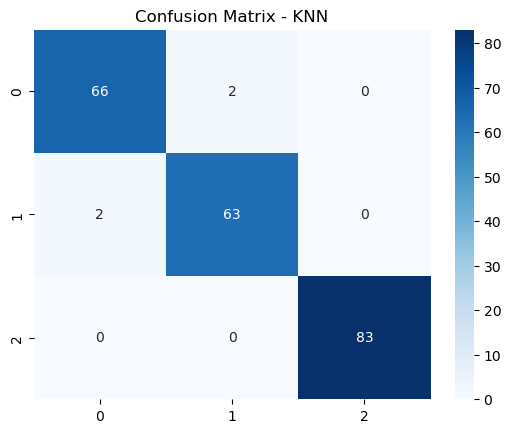

In [118]:
cm_knn=confusion_matrix(y_test,pred_knn)

sb.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - KNN")
plt.show()

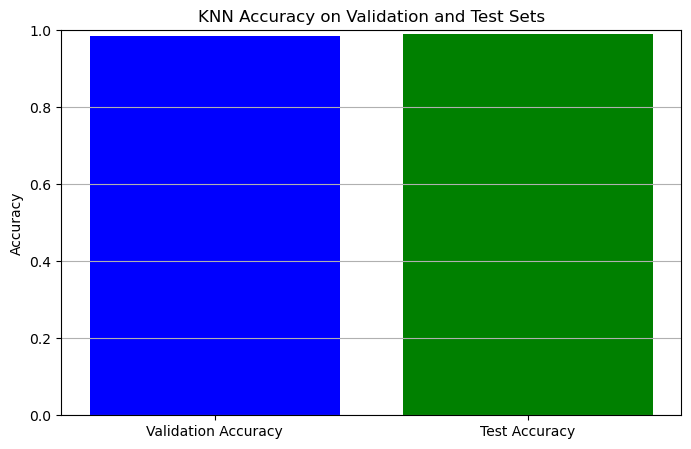

In [91]:
# Train your machine learning model on the training data and make predictions
mod_knn=RandomForestClassifier()
mod_knn.fit(x_train,y_train)

# Evaluate on validation data and calculate accuracy
val_predictions = mod_knn.predict(x_val) 
val_accuracy = accuracy_score(y_val, val_predictions)

# Evaluate on test data and calculate accuracy
test_predictions = mod_knn.predict(x_test) 
test_accuracy = accuracy_score(y_test, test_predictions)

# Plotting the accuracy
labels = ['Validation Accuracy', 'Test Accuracy']
accuracy_scores = [val_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('KNN Accuracy on Validation and Test Sets')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(axis='y')
plt.show()

### Multiplayer perceptron

In [74]:
from sklearn.neural_network import MLPClassifier
# Create an MLP classifier with optional parameters
mod_mlp = MLPClassifier()
# Fit the model to the training data
mod_mlp.fit(x_train, y_train)
# Make predictions on the test data
pred_mlp = mod_mlp.predict(x_test)
# Calculate the accuracy of the model
acc_mlp = accuracy_score(y_test, pred_mlp)
# Print the accuracy in percentage form
print(acc_mlp * 100, '%')

94.9074074074074 %


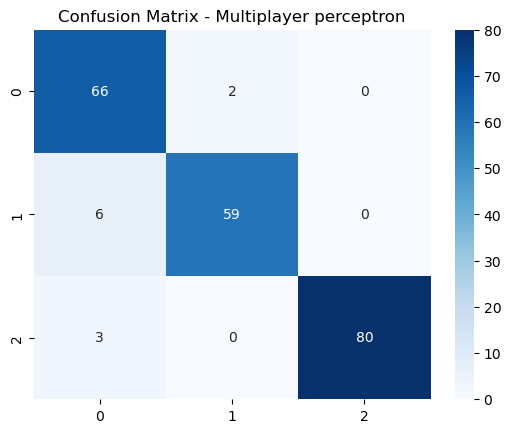

In [117]:
cm_mlp=confusion_matrix(y_test,pred_mlp)

sb.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Multiplayer perceptron")
plt.show()

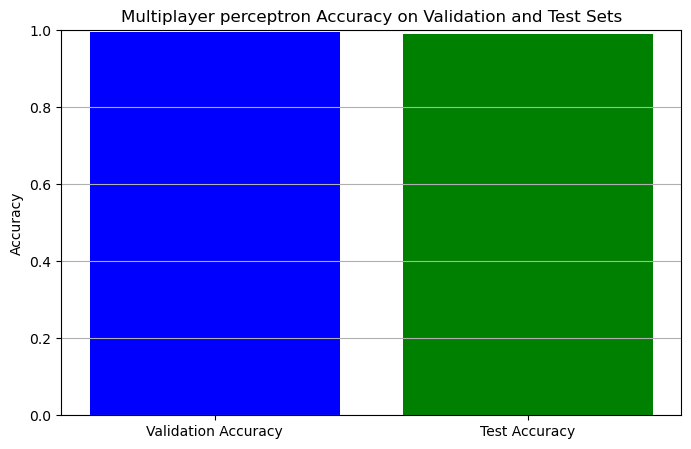

In [92]:
# Train your machine learning model on the training data and make predictions
mod_mlp=RandomForestClassifier()
mod_mlp.fit(x_train,y_train)

# Evaluate on validation data and calculate accuracy
val_predictions = mod_mlp.predict(x_val) 
val_accuracy = accuracy_score(y_val, val_predictions)

# Evaluate on test data and calculate accuracy
test_predictions = mod_mlp.predict(x_test) 
test_accuracy = accuracy_score(y_test, test_predictions)

# Plotting the accuracy
labels = ['Validation Accuracy', 'Test Accuracy']
accuracy_scores = [val_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('Multiplayer perceptron Accuracy on Validation and Test Sets')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(axis='y')
plt.show()

### Navie Bayes

In [76]:
from sklearn.naive_bayes import GaussianNB
# Create a Gaussian Naive Bayes classifier
mod_nb = GaussianNB()
# Fit the model to the training data
mod_nb.fit(x_train, y_train)
# Make predictions on the test data
pred_nb = mod_nb.predict(x_test)
# Calculate the accuracy of the model
acc_nb = accuracy_score(y_test, pred_nb)
# Print the accuracy in percentage form
print(acc_nb * 100, '%')

93.51851851851852 %


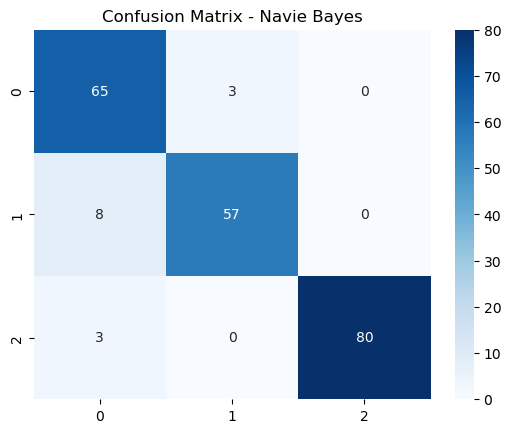

In [116]:
cm_nb=confusion_matrix(y_test,pred_nb)

sb.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Navie Bayes")
plt.show()

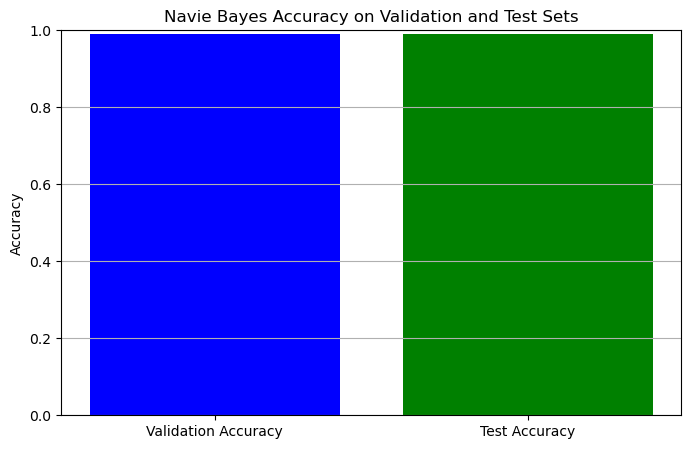

In [93]:
# Train your machine learning model on the training data and make predictions
mod_nb=RandomForestClassifier()
mod_nb.fit(x_train,y_train)

# Evaluate on validation data and calculate accuracy
val_predictions = mod_nb.predict(x_val) 
val_accuracy = accuracy_score(y_val, val_predictions)

# Evaluate on test data and calculate accuracy
test_predictions = mod_nb.predict(x_test) 
test_accuracy = accuracy_score(y_test, test_predictions)

# Plotting the accuracy
labels = ['Validation Accuracy', 'Test Accuracy']
accuracy_scores = [val_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('Navie Bayes Accuracy on Validation and Test Sets')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(axis='y')
plt.show()

### gradient boosting

In [78]:
from sklearn.ensemble import GradientBoostingClassifier
# Create a Gradient Boosting classifier with optional parameters
mod_gb = GradientBoostingClassifier()
# Fit the model to the training data
mod_gb.fit(x_train, y_train)
# Make predictions on the test data
pred_gb = mod_gb.predict(x_test)
# Calculate the accuracy of the model
acc_gb = accuracy_score(y_test, pred_gb)
# Print the accuracy in percentage form
print(acc_gb * 100, '%')

99.07407407407408 %


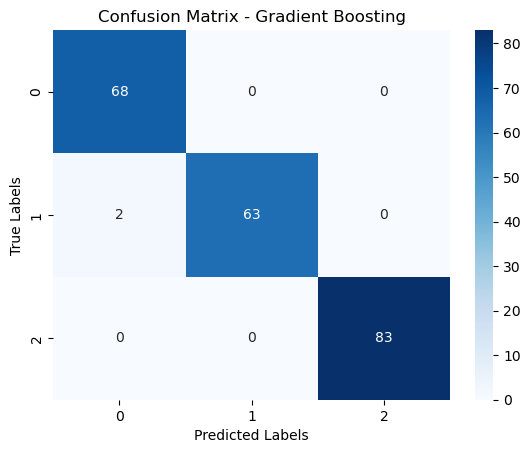

In [124]:
cm_gb=confusion_matrix(y_test,pred_gb)

sb.heatmap(cm_gb, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

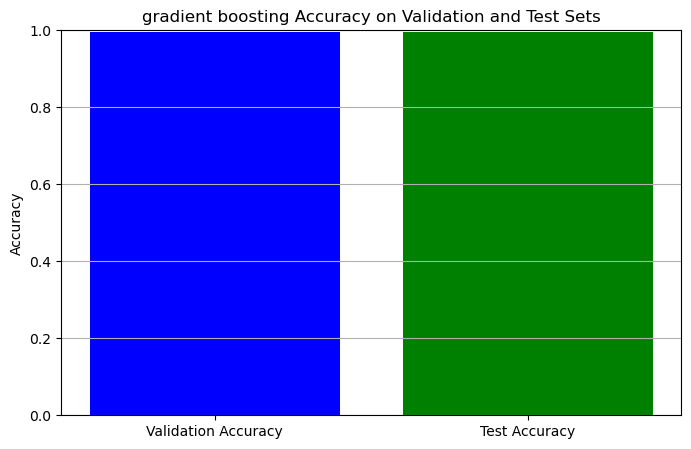

In [94]:
# Train your machine learning model on the training data and make predictions
mod_gb=RandomForestClassifier()
mod_gb.fit(x_train,y_train)

# Evaluate on validation data and calculate accuracy
val_predictions = mod_gb.predict(x_val) 
val_accuracy = accuracy_score(y_val, val_predictions)

# Evaluate on test data and calculate accuracy
test_predictions = mod_gb.predict(x_test) 
test_accuracy = accuracy_score(y_test, test_predictions)

# Plotting the accuracy
labels = ['Validation Accuracy', 'Test Accuracy']
accuracy_scores = [val_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('gradient boosting Accuracy on Validation and Test Sets')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(axis='y')
plt.show()

### Linear Regression

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Create a Linear Regression model
mod_lr = LinearRegression()
# Fit the model to the training data
mod_lr.fit(x_train, y_train)
# Make predictions on the test data
pred_lr = mod_lr.predict(x_test)
# Calculate the mean squared error (MSE) of the predictions
mse_lr = mean_squared_error(y_test, pred_lr)
# Print the mean squared error
print("Mean Squared Error:", mse_lr)

Mean Squared Error: 0.1869693043732123


### Polynomial Regression

In [81]:
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial features up to a certain degree
degree = 2 # degree
poly_features = PolynomialFeatures(degree=degree)
x_train_poly = poly_features.fit_transform(x_train)
x_test_poly = poly_features.transform(x_test)
# Create a Linear Regression model
mod_poly = LinearRegression()
# Fit the model to the polynomial features of the training data
mod_poly.fit(x_train_poly, y_train)
# Make predictions on the polynomial features of the test data
pred_poly = mod_poly.predict(x_test_poly)
# Calculate the mean squared error (MSE) of the predictions
mse_poly = mean_squared_error(y_test, pred_poly)
# Print the mean squared error
print("Mean Squared Error:", mse_poly)

Mean Squared Error: 0.06865168210402388


### XGBoost

In [111]:
import xgboost as xgb
# Create an XGBoost Regressor with optional parameters
mod_xgb = xgb.XGBRegressor()
# Fit the model to the training data
mod_xgb.fit(x_train, y_train)
# Make predictions on the test data
pred_xgb = mod_xgb.predict(x_test)
# Calculate the mean squared error (MSE) of the predictions
mse_xgb = mean_squared_error(y_test, pred_xgb)
# Print the mean squared error
print("Mean Squared Error (XGBoost):", mse_xgb)

Mean Squared Error (XGBoost): 0.01674342260148334


In [112]:
# Assuming you have your predictions for classification
pred_xgb_class = mod_xgb.predict(x_test)
# Convert predictions to binary class labels if needed
pred_labels = [1 if p > 0.5 
               else 0 
               for p in pred_xgb_class]
# Calculate accuracy score
acc_xgb = accuracy_score(y_test, pred_labels)
# Print the accuracy score
print("Accuracy Score (XGBoost):", acc_xgb*100)

Accuracy Score (XGBoost): 59.72222222222222


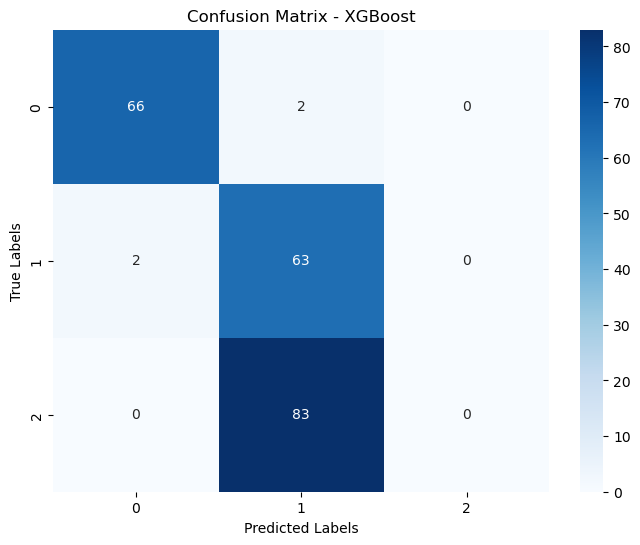

In [114]:
# Assuming you have 'y_test' and 'pred_labels'
cm_xgb = confusion_matrix(y_test, pred_labels)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

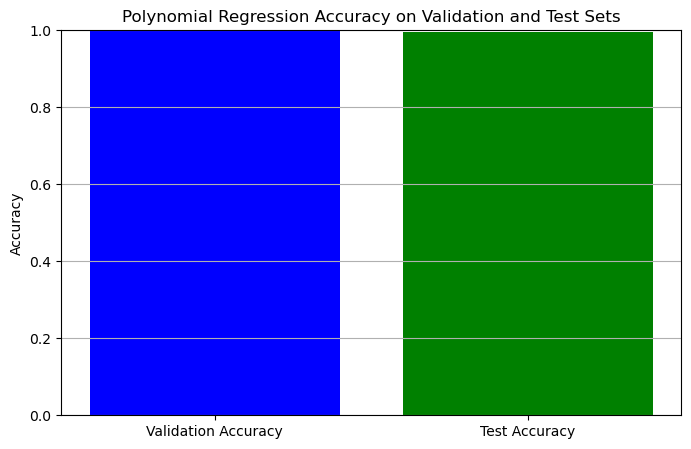

In [95]:
# Train your machine learning model on the training data and make predictions
mod_poly=RandomForestClassifier()
mod_poly.fit(x_train,y_train)

# Evaluate on validation data and calculate accuracy
val_predictions = mod_poly.predict(x_val) 
val_accuracy = accuracy_score(y_val, val_predictions)

# Evaluate on test data and calculate accuracy
test_predictions = mod_poly.predict(x_test) 
test_accuracy = accuracy_score(y_test, test_predictions)

# Plotting the accuracy
labels = ['Validation Accuracy', 'Test Accuracy']
accuracy_scores = [val_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('Polynomial Regression Accuracy on Validation and Test Sets')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.grid(axis='y')
plt.show()

In [98]:
ACCURACY=pd.DataFrame({'Algorithm':['Logistic Regression', 'Random Forest','Adaboost','SVM','Decision Tree','KNN','Multiplayer perceptron','Navie Bayes','gradient boosting','XGBoost'],
                       'Accuracy':[acc_logi*100,acc_RF*100,acc_ada*100,acc_svc*100, acc_dt*100, acc_knn*100,acc_mlp*100, acc_nb*100,acc_gb*100,acc_xgb*100]})

In [99]:
color_style = 'style="text-indent: 300px; color: blue;"'
header_html = f'<h1 {color_style}>Accuracy of Models</h1>'
display(HTML(header_html))
ACCURACY

,Algorithm,Accuracy
0,Logistic Regression,95.370370
1,Random Forest,99.074074
2,Adaboost,87.962963
3,SVM,99.074074
4,Decision Tree,98.611111
5,KNN,98.148148
6,Multiplayer perceptron,94.907407
7,Navie Bayes,93.518519
8,gradient boosting,99.074074
9,XGBoost,59.722222


In [131]:
# class weight 
TRAIN_IMG_COUNT = 578
COUNT_0 = 40  #ms
COUNT_1 = 129 #mr
COUNT_2 = 409 #normal
weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
class_weight

{0: 4.816666666666666, 1: 1.4935400516795865, 2: 0.4710676446617767}

## LSTM Model

In [125]:
x_train_lstm = x_train
x_val_lstm = x_val
x_test_lstm = x_test

y_train_lstm = y_train
y_val_lstm = y_test
y_test_lstm = y_val

In [126]:
print("Input x_train_lstm Data Shape:", x_train_lstm.shape)
print("Target y_train_lstm Data Shape:", y_train_lstm.shape)
print("-------------------------------------------")
print("Input x_val_Gru Data Shape:", x_val_lstm.shape)
print("Target y_val_Gru Data Shape:", y_val_lstm.shape)
print("-------------------------------------------")
print("Input x_test_Gru Data Shape:", x_test_lstm.shape)
print("Target y_test_Gru Data Shape:", y_test_lstm.shape)

Input x_train_Gru Data Shape: (1008, 52)
Target y_train_Gru Data Shape: (1008,)
-------------------------------------------
Input x_val_Gru Data Shape: (216, 52)
Target y_val_Gru Data Shape: (216,)
-------------------------------------------
Input x_test_Gru Data Shape: (216, 52)
Target y_test_Gru Data Shape: (216,)


In [134]:

# Assuming x_train_Gru has shape (1008, 52)
x_train_Gru = np.random.random((1008, 52))  # Replace this with your actual data

# Add an additional dimension of size 1
x_train_Gru_reshaped = x_train_Gru[:, :, np.newaxis]

print("Original shape:", x_train_Gru.shape)
print("New shape:", x_train_Gru_reshaped.shape)

Original shape: (1008, 52)
New shape: (1008, 52, 1)


In [127]:
lstm_model = Sequential()

lstm_model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))

lstm_model.add(LSTM(256, return_sequences=True))
lstm_model.add(LSTM(128))
lstm_model.add(BatchNormalization())


lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(3, activation='softmax'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 52, 2048)          12288     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 2048)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 2048)          8192      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 1024)          10486784  
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 1024)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 1024)          4096      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 512)           2

In [128]:
import h5py

optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cb = [
    EarlyStopping(
        patience=20,
        monitor='val_accuracy',  # Monitor validation accuracy
        mode='max',  # Maximize the monitored metric
        restore_best_weights=True  # Restore the model's best weights when stopping early
    )
]

In [138]:
history_LSTM = lstm_model.fit(
    x_train_Gru_reshaped, y_train_lstm,
    validation_data=(x_val_lstm, y_val_lstm),
    batch_size=8,
    epochs=250,
    class_weight=class_weight,
    callbacks=cb
)

ValueError: You are passing a target array of shape (1008, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.